# E-commerce — Выявление профилей потребления

**Описание проекта**

"Пока все ещё тут" — это интернет-магазин, где клиенты могут находить все необходимое для создания уюта в своем доме. Магазин предлагает широкий ассортимент товаров для дома, начиная от мебели и текстиля, заканчивая кухонными принадлежностями и декором.
Проект направлен на оптимизацию маркетинговых стратегий и улучшение пользовательского опыта в онлайн-магазине, а также создание более персонализированных предложений.

**Задача:** сегментировать покупателей по профилю потребления для осуществления рекламных рассылок.

**План работы:**
  - Открыть файл с данными и изучить общую информацию. Проверить правильность типов данных, и изменить при необходимости.
  - Провести предобработку данных: Проверка дубликатов, пропусков и именования столбцов. Оценить дубликаты заказов в разрезе без времени. Выяснить с помощью графиков и статистики, есть ли выбросы и аномалии в столбцах `quantity` и `price`. Создать отдельный столбец `category` с категориями товаров.
  - Сегментировать покупателей по профилю потребления с помощью RFM анализа. Добавить столбец `total_price`(общая стоимость заказа цена за товар * кол-во товара) и `only_date`(дата без времени). Определить дату начала анализа и его промежуток. С помощью RFM анализа разбить покупателей на 4 категории:
        1. Lost Customer
        1. Low-value customer
        1. Medium value customer
        1. Top Customer
  - Проверить кластеризацию с помощью t-теста для частоты покупок и для среднего чека, предварительно проверив нормальность распределения. Если выборки распределены ненормально, будем использовать непараметрический тест Манна-Уитни.
      - Гипотеза H0 (нулевая гипотеза) для среднего чека:
        H0: Средние значения среднего чека в двух кластерах (сегментах) равны.
      - Гипотеза H1 (альтернативная гипотеза) для среднего чека:
        H1: Средние значения среднего чека в двух кластерах (сегментах) различаются.
      - Гипотеза H0 для частоты покупок:
        H0: Средние значения частоты покупок в двух кластерах (сегментах) равны.
      - Гипотеза H1 для частоты покупок:
        H1: Средние значения частоты покупок в двух кластерах (сегментах) различаются.
  - Проанализировать сегменты по сумме заказа с помощью графика boxplot. Создать функцию vis_clasters_combined, которая визуализирует графики зависимости % проданных товаров и % суммы продаж от даты для разных категорий для конкретного кластера. Оценив результаты, выдвинуть рекомендации по проведению рекламной кампании в виде таблицы Категория/Сегмент: на пересечении сезон для рассылки.


**Ожидаемые результаты:**

- Качественная сегментация покупателей, которая позволит более точно нацеливать маркетинговые стратегии.
- Повышение эффективности персонализированных предложений.
- Улучшение пользовательского опыта и укрепление лояльности клиентов.
- Глубокое понимание предпочтений и потребностей различных сегментов покупателей.
- Внедрение статистически обоснованных подходов для принятия решений в сфере маркетинга и товарной стратегии.

**Описание данных** ecom_dataset_upd.csv:
- `date` — дата заказа;
- `customer_id` — идентификатор покупателя;
- `order_id` — идентификатор заказа;
- `product` — наименование товара;
- `quantity` — количество товара в заказе;
- `price` — цена товара.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import datetime as dt
import seaborn as sns

## Откроем файл с данными и изучим общую информацию



In [2]:
try:
    df = pd.read_csv('/content/ecom_dataset_upd.csv')
except:
    df = pd.read_csv('/datasets/ecom_dataset_upd.csv')


In [3]:
# Просмотрим общую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7474 entries, 0 to 7473
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         7474 non-null   int64  
 1   customer_id  7474 non-null   object 
 2   order_id     7474 non-null   int64  
 3   product      7474 non-null   object 
 4   quantity     7474 non-null   int64  
 5   price        7474 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 350.5+ KB


Видно, что столбец date нуждается в изменение типа на datetime

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
df.head(5)

,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0


**Вывод**:

1. Типы данных соответствуют ожидаемому, кроме столбца `date`
2. Перевели столбец `date` к типу datetime

## Подготовим данные

Проверим правильность названия столбцов

In [5]:
df.columns

Index(['date', 'customer_id', 'order_id', 'product', 'quantity', 'price'], dtype='object')

Посмотрим, есть ли явные дубликаты

In [6]:
df.duplicated().sum()

0

Проверим датасет на пропуски

In [7]:
df.isna().sum()

date           0
customer_id    0
order_id       0
product        0
quantity       0
price          0
dtype: int64

Посмотрим дубликаты в разрезе без времени

In [8]:
pd.set_option('display.max_rows', 10)
df[df.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'])]

,date,customer_id,order_id,product,quantity,price
58,2018-10-02 18:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
59,2018-10-02 19:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
60,2018-10-02 20:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
63,2018-10-03 04:00:00,b731df05-98fa-4610-8496-716ec530a02c,68474,Доска гладильная Eurogold Professional 130х48 ...,1,3299.0
94,2018-10-04 13:00:00,32de7df8-8d4f-4c84-a7b9-c41d00dd83ba,68522,Эвкалипт Гунни d-17 см h-60 см,1,1409.0
...,...,...,...,...,...,...
6706,2019-10-28 10:00:00,57cc80a2-2610-4eef-9457-e7c3bf0c72f0,70960,Сумка-тележка 2-х колесная Gimi Argo красная,1,1087.0
6711,2019-10-28 21:00:00,cb65d08a-dae7-4890-aef0-bb9f79055e02,73108,Мирт d-9 см h-15 см,1,134.0
6728,2019-10-31 00:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0
6729,2019-10-31 02:00:00,ffaeab76-3a8d-49ee-860f-17273b2fc8a2,73136,"Таз пластмассовый со стиральной доской (Иж), 1...",1,397.0


Видны различные дубликаты одного и того же заказа. Оставим последний результат, как итоговое решение покупателя.

In [9]:
# Посмотрим, сколько процентов подобных дубликатов есть в датасете
df[df.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'])].shape[0] / df.shape[0] * 100

24.939791276424938

In [10]:
# Создадим копию датасета без дубликатов
df_new = df.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'], keep='last')

In [11]:
df_new.shape[0]

5610

In [12]:
# Проверим на наличие заказов совершенных более чем одним покупателем.
df_new[df_new.duplicated(subset=['order_id', 'product', 'quantity', 'price'])].head(6)

,date,customer_id,order_id,product,quantity,price
538,2018-10-30 21:00:00,c1dd5c0e-51db-4a5d-91a3-5374cb20043d,68785,"Сиденье в ванну раздвижное, белый, СВ5, НИКА",1,374.0
1160,2018-12-10 16:00:00,e3805ccd-2d64-4d0e-92dd-902293555c35,69283,Сушилка для белья на батарею НИКА СБ6-65 двухъ...,1,164.0
1209,2018-12-15 07:00:00,22e4d79f-3613-4c22-8b01-7f880120bf5a,69345,Сушилка для белья Attribute ПРИМА 18 м синяя A...,1,974.0
1258,2018-12-18 20:00:00,caaa3f41-c9ab-4e3d-8b75-94e1d3a8d7b4,69410,Муляж Желудь 2 шт,3,22.0
1384,2018-12-26 23:00:00,e0461045-4fcc-4731-8837-509f6534512a,69485,Набор столовых приборов 24 предмета FARANDOLE ...,1,1274.0
1583,2019-01-23 19:00:00,a684bf62-f75c-4e82-aa74-6d02b127b439,69833,Чехол Eurogold Clean Metallic металлизированый...,2,299.0


In [13]:
# Посмотрим, сколько процентов подобных дубликатов есть в датасете
df_new[df_new.duplicated(subset=['order_id', 'product', 'quantity', 'price'])].shape[0] / df_new.shape[0] * 100

0.5882352941176471

In [14]:
# Создадим копию датасета без дубликатов, оставим последний заказ, как правильный вариант заказа
df_new = df_new.drop_duplicates(subset=['order_id', 'product', 'quantity', 'price'], keep='last')

In [15]:
df_new.shape[0]

5577

Создадим отдельный столбец с категориями товаров. Для этого просмотрим все товары и их названия

In [16]:
unique_products = df['product'].value_counts()

In [17]:
pd.set_option('display.max_rows', None)
unique_products.sort_index()

Tepмокружка AVEX Freeflow 700 мл зеленый AVEX0759                                                                                    2
Tepмокружка AVEX Freeflow 700 мл сталь AVEX0776                                                                                      1
Tepмокружка AVEX Recharge 500 мл голубой AVEX0681                                                                                    2
Ёрш бутылочный с металлической ручкой малый Y64 1807002                                                                              1
Ёрш для бутылки из натурального волокна и металла 23 см кремовый, Burstenmann, 0473/0003                                             1
Ёрш радиаторный без ручки 1807007                                                                                                    2
Ёрш унитазный пластмассовый, Ваир 1712002                                                                                            1
Ёрш унитазный с деревянной ручкой , Ваир 1712012       

Создадим словарь с категориями

In [18]:
categories_dict = {
    'Товары для кухни': [],
    'Товары для ванной комнаты': [],
    'Товары для уборки': [],
    'Товары для глажения': [],
    'Садовые товары': [],
    'Искусственные цветы и растения': [],
    'Хозяйственные товары': [],
    'Посуда и кухонные принадлежности': [],
    'Товары для хранения и организации': [],
    'Товары для дома и интерьера': [],
}


for name in unique_products.index:
    if name.startswith('Tepмокружка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Ёрш'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Автоматическая щетка'):
        categories_dict['Товары для уборки'].append(name)
    elif 'рассада' in name:
        categories_dict['Искусственные цветы и растения'].append(name)
    elif  name.startswith('Антижир'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Антинакипин'):
        categories_dict['Товары для уборки'].append(name)
    elif 'налет' in name:
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Бак для белья'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Бальзам для мытья'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Банка'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Бельевые прищепки'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Бензин'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Бидон'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Блюд'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Бульонница'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Ваза'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Вакуумный пакет'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Ванна'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Вантуз'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Ведро'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Веник'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Венчик'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Веревка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Весы'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Вешалк'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Вилка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Вкладыши'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Гипоаллергенный концентрированный гель'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Гладильная доска'):
        categories_dict['Товары для глажения'].append(name)
    elif  'скатерть' in name:
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Губка'):
        categories_dict['Товары для уборки'].append(name)
    elif  'белье' in name:
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  'цветов' in name:
        categories_dict['Искусственные цветы и растения'].append(name)
    elif  name.startswith('Декоративная коробка'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Держатель'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Дозатор для мыла'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Доска гладильная'):
        categories_dict['Товары для глажения'].append(name)
    elif  name.startswith('Доска разделочная'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Емкость'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Ерш'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  'мыло' in name:
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Завертка форточная'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Запасная насадка для ерша'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Защитная соль'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Защитный экран'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Зубная паста'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Измельчитель'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Измерительный'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Картофелемялка'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Кастрюля'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Кипятильник'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Кисточка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Ковер'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Коврик '):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Ковш'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Ковёр'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Кольца для штор'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Комод'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  'ванной' in name:
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Комплект для мытья полов'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Комплект махровых'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Кондиционер'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Контейнер'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Концентрат'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Корзина'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Корзинка'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Короб'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Коробка'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Корыто'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Котел'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Кофр'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Крепеж'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Кружка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Крышка'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Крючок'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Кувшин'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Кухонн'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Лестница'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Линейка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Ложка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Ложка обувная'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Лопатка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Лоток'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Масленка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Махров'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Мерный'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Мешок'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Миксер'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Мини-сковорода'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Миска'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Модульная'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Мусорный'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Мыл'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Набор Vileda'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Набор бокалов'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Набор вешалок'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Набор для пикника'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Набор инструментов'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Набор ковров'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Набор кружек'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Набор кухонных'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Набор махровых'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Набор ножей'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Набор посуды'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Набор прецизионных'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Набор прищепок'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Набор сверел'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Набор стаканов'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Набор столовых'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Набор форм'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Набор фужеров'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Набор эмалированных'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Наволочка'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Наматрасник'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Насадка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Настенная'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Настольная'):
        categories_dict['Товары для глажения'].append(name)
    elif  name.startswith('Нетканые'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Нож'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Овоще'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Одеяло'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Окномойка'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Ополаскиватель'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Орехоколка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Основание'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Отбеливатель'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Отделитель'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Отжим'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Паста для полировки'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Паста зубная'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Пена'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Перчатки'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Петля'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Плед'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Плечики'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Подвесное кашпо'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Подголовник'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Подкладка'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Пододеяльник'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Подрукавник'):
        categories_dict['Товары для глажения'].append(name)
    elif  name.startswith('Подставка'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Подушка'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Покрывало'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Покрытие'):
        categories_dict['Товары для глажения'].append(name)
    elif  name.startswith('Полк'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Полотенце'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Половник'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Пресс'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Прищепки'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Пробка'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Просеиватель'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Простын'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Противень'):
        categories_dict['Товары для кухни'].append(name)
    elif  name.startswith('Пружина'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Пылесос'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Пьезозажигалка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Разделочная'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Рассекатель'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Решетка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Ролик'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Рукав'):
        categories_dict['Товары для глажения'].append(name)
    elif  name.startswith('Ручка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Рыбочистка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Салатник'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Салфетка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Салфетница'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Сахарница'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Сверло'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Светильник'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Сервировочная'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Сетка'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Сиденье'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Сито'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Скалка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Скатерть'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Складная'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Складной'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Сковорода'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Скребок'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Сменная насадка'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Сменный блок'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Сметка с совком'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Совок'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Соко'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Сотейник'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Средство'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Стакан для ванной'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Стакан'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Стеклянная'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Стеллаж'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Стиральный'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Столов'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Стремянк'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Стяжк'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Сумка'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Сумка-тележка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Сушилка'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Таз'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Тарелка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Тележка'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Терка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Термокружка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Термометр'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Термос'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Термостакан'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Ткань'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Толкушка'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Тортница'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Тряпка'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Тряпкодержатель'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Универсальное'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Увлажняющая'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Уголок'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Урна'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Утюг'):
        categories_dict['Товары для глажения'].append(name)
    elif  name.startswith('Фал'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Фарфоровая'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Фен'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Форма'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Фоторамка'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Халат'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Хлебница'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Холодная'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Чайн'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Чехол'):
        categories_dict['Товары для хранения и организации'].append(name)
    elif  name.startswith('Чистящий'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Швабра'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Шило'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Шнур'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Шпагат'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Шпингалет'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Шприц'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Штанга'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Штангенциркуль'):
        categories_dict['Хозяйственные товары'].append(name)
    elif  name.startswith('Штора'):
        categories_dict['Товары для ванной комнаты'].append(name)
    elif  name.startswith('Щетка'):
        categories_dict['Товары для уборки'].append(name)
    elif  name.startswith('Электроштопор'):
        categories_dict['Посуда и кухонные принадлежности'].append(name)
    elif  name.startswith('Этажерка'):
        categories_dict['Товары для дома и интерьера'].append(name)
    elif  name.startswith('Ящик'):
        categories_dict['Товары для хранения и организации'].append(name)
    else:
       categories_dict['Искусственные цветы и растения'].append(name)

    # Добавьте другие условия для других категорий


In [19]:
pd.set_option('display.max_rows', 10)

In [20]:
# Создадим новый столбец с категориями
df_new['category'] = df_new['product'].apply(lambda x: next((category for category, products in categories_dict.items() if any(product in x for product in products)), None))

In [21]:
df_new.head(5)

,date,customer_id,order_id,product,quantity,price,category
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,Искусственные цветы и растения
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,Искусственные цветы и растения
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,Искусственные цветы и растения
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,Искусственные цветы и растения
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,Искусственные цветы и растения


In [22]:
# Посмотрим сколько заказов есть для каждой категории
category_counts = df_new['category'].value_counts()

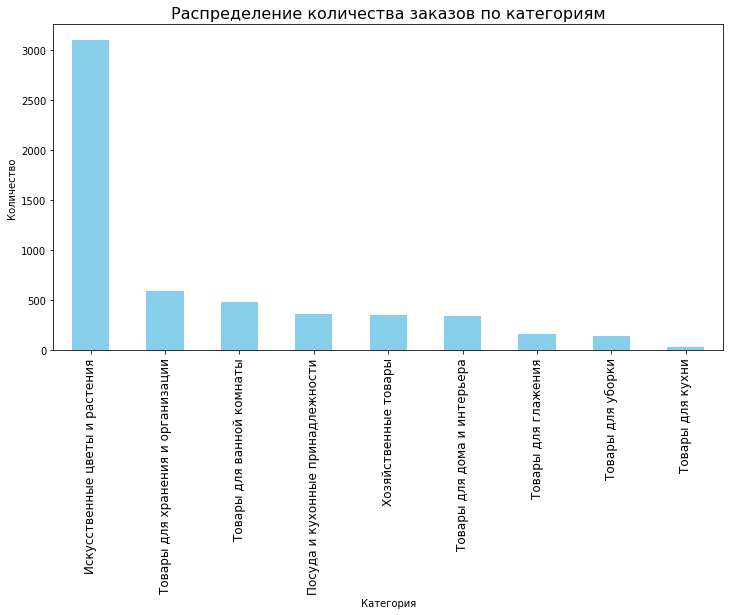

In [23]:
# Создадим график
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', color='skyblue')

plt.title('Распределение количества заказов по категориям', fontsize=16)
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(fontsize=12)

plt.show()

Большинство покупок приходится на цветы и растения

Просмотрим столбцы `quantity` и `price` на наличие выбросов и аномалий

In [24]:
# Просмотрим информацию о кол-ве товаров в заказах
df_new['quantity'].describe()

count    5577.000000
mean        2.588309
std        16.441086
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

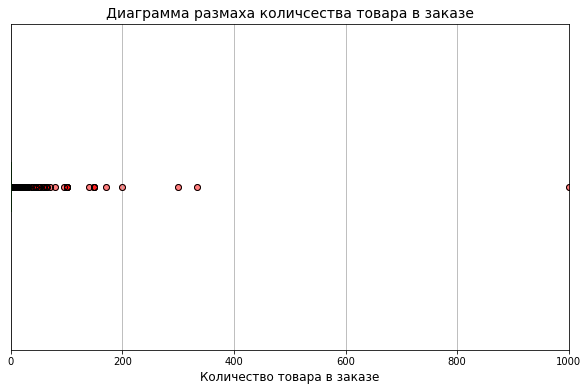

In [25]:
#Построим диаграмму размаха для столбца quantity
df_new.boxplot(column='quantity', figsize=(10, 6), vert=False)
plt.xlim(0, 1000)
plt.xlabel('Количество товара в заказе', fontsize=12)
plt.yticks([])
plt.title('Диаграмма размаха количсества товара в заказе', fontsize=14)
plt.scatter(x=df_new['quantity'], y=np.repeat(1, len(df_new['quantity'])), color='red', alpha=0.5)
plt.show()

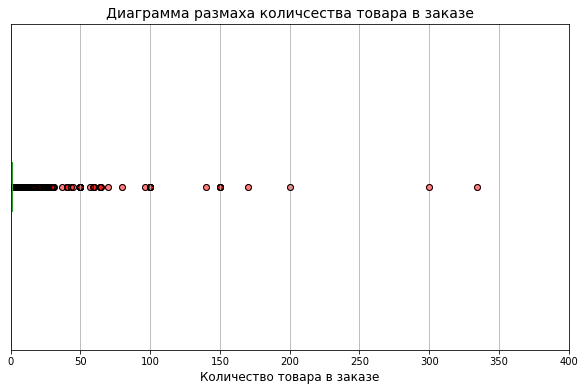

In [26]:
#Построим диаграмму размаха для столбца quantity в другом масштабе
df_new.boxplot(column='quantity', figsize=(10, 6), vert=False)
plt.xlim(0, 400)
plt.xlabel('Количество товара в заказе', fontsize=12)
plt.yticks([])
plt.title('Диаграмма размаха количсества товара в заказе', fontsize=14)
plt.scatter(x=df_new['quantity'], y=np.repeat(1, len(df_new['quantity'])), color='red', alpha=0.5)
plt.show()

Виден явный выброс в значении 1000. Более 75% заказов содержат 1 товар.
Просмотрим внимательные отдельные заказы, в топ 10 по кол-ву

In [27]:
# Выведем топ 10 заказов по кол-ву товаров
df_new.sort_values(by='quantity', ascending=False).head(10)

,date,customer_id,order_id,product,quantity,price,category
5456,2019-06-18 15:00:00,312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6,71743,"Вантуз с деревянной ручкой d14 см красный, Bur...",1000,675.0,Товары для ванной комнаты
5071,2019-06-11 07:00:00,146cd9bf-a95c-4afb-915b-5f6684b17444,71668,Вешалки мягкие для деликатных вещей 3 шт шоколад,334,148.0,Товары для дома и интерьера
3961,2019-05-20 21:00:00,5d189e88-d4d6-4eac-ab43-fa65a3c4d106,71478,Муляж ЯБЛОКО 9 см красное,300,51.0,Искусственные цветы и растения
1158,2018-12-10 14:00:00,a984c5b7-ff7e-4647-b84e-ef0b85a2762d,69289,"Ручка-скоба РС-100 белая *Трибатрон*, 1108035",200,29.0,Хозяйственные товары
568,2018-11-01 08:00:00,aa42dc38-780f-4b50-9a65-83b6fa64e766,68815,Муляж ЯБЛОКО 9 см красное,170,51.0,Искусственные цветы и растения
2431,2019-03-23 10:00:00,685d3d84-aebb-485b-8e59-344b3df8b3d3,70841,Плечики пластмассовые Размер 52 - 54 Тула 1205158,150,20.0,Товары для хранения и организации
267,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,Пружина дверная 240 мм оцинкованная (Д-19 мм) ...,150,38.0,Хозяйственные товары
266,2018-10-16 08:00:00,cd09ea73-d9ce-48c3-b4c5-018113735e80,68611,"Крепеж для пружины дверной, 1107055",150,19.0,Товары для дома и интерьера
586,2018-11-02 11:00:00,0c5aaa88-e346-4f87-8f7a-ad8cbc04e965,68831,Муляж ЯБЛОКО 9 см красное,140,59.0,Искусственные цветы и растения
6535,2019-10-07 11:00:00,d933280e-5372-448f-be44-b269c8bafc2a,72885,"Крепеж для пружины дверной оцинкованный, 1107054",100,19.0,Товары для дома и интерьера


Можно сделать вывод в сторону выброса в заказе с 1000 позиций. Остальных клиентов оставим, как оптовых

In [28]:
df_new = df_new.query('quantity < 1000')

In [29]:
# Просмотрим информацию о стоимости товаров
df_new['price'].describe()

count     5576.000000
mean       530.301665
std        972.842714
min          9.000000
25%         90.000000
50%        150.000000
75%        524.000000
max      14917.000000
Name: price, dtype: float64

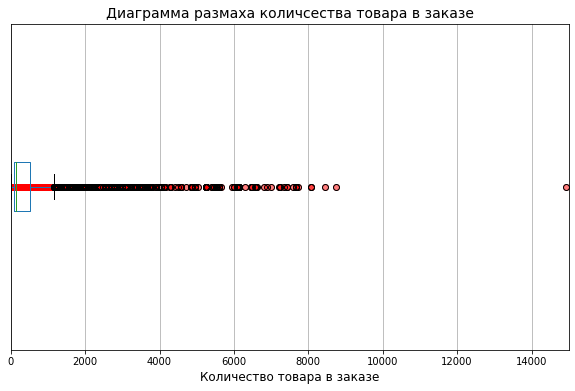

In [30]:
#Построим диаграмму размаха для столбца price
df_new.boxplot(column='price', figsize=(10, 6), vert=False)
plt.xlim(0, 15000)
plt.xlabel('Количество товара в заказе', fontsize=12)
plt.yticks([])
plt.title('Диаграмма размаха количсества товара в заказе', fontsize=14)
plt.scatter(x=df_new['price'], y=np.repeat(1, len(df_new['price'])), color='red', alpha=0.5)
plt.show()

In [31]:
# Просмотрим аномальную цену
df_new.query('price >= 14000'). head(10)

,date,customer_id,order_id,product,quantity,price,category
5992,2019-07-29 17:00:00,0d87f4ae-465a-4fac-81e6-5d629761783e,72139,Сушилка уличная Leifheit 85210 LINOMATIC V 400...,1,14917.0,Товары для ванной комнаты


В столбце `price` аномалий не обнаружено. Все цены лежат в допустимых значениях.

**Вывод:**
1. Ошибок в названии столбцов не обнаружено
2. Явных дубликатов не обнаружено
3. Пропусков не обнаружено
4. Дубликаты в разрезе без времени : видны различные дубликаты одного и того же заказа. Оставим последний результат, как итоговое решение покупателя.(25% дубликатов). Оставили последний заказ, среди заказов совершенных более чем одним покупателем.
5. Создадим отдельный столбец `category` с категориями товаров
6. Можно сделать вывод в сторону выброса в заказе с 1000 позициями. Остальных клиентов оставим, как оптовых.
7. В стобце `price` аномалий не обнаружено. Все цены лежат в допустимых значениях.

## RFM-анализ

In [32]:
# Добавим столбец total_price(общая стоимость заказа цена за товар * кол-во товара) и only_date(дата без времени)
df_new['only_date'] = df_new['date'].dt.date
df_new['total_price'] = df_new['price'] * df_new['quantity']
df_new

,date,customer_id,order_id,product,quantity,price,category,only_date,total_price
0,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,Искусственные цветы и растения,2018-10-01,142.0
1,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,Искусственные цветы и растения,2018-10-01,194.0
2,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,Искусственные цветы и растения,2018-10-01,112.0
3,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,Искусственные цветы и растения,2018-10-01,179.0
4,2018-10-01 00:00:00,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,Искусственные цветы и растения,2018-10-01,112.0
...,...,...,...,...,...,...,...,...,...
7469,2020-01-30 21:00:00,63208953-a8e4-4f77-9b47-3a46e7b72eee,104002,томата (помидор) Черниченский черри № 116 сорт...,2,38.0,Искусственные цветы и растения,2020-01-30,76.0
7470,2020-01-30 22:00:00,d99d25f1-4017-4fcd-8d29-c580cc695a1a,107336,Дендробиум Санок Анна Грин 1 ствол d-12 см,1,869.0,Искусственные цветы и растения,2020-01-30,869.0
7471,2020-01-31 02:00:00,2c9bd08d-8c55-4e7a-9bfb-8c56ba42c6d6,106336,Подставка для обуви резиновая Attribute 80x40 ...,1,354.0,Товары для дома и интерьера,2020-01-31,354.0
7472,2020-01-31 12:00:00,cdd17932-623e-415f-a577-3b31312fd0e2,102002,Тагетис крупноцветковый рассада однолетних цве...,1,128.0,Искусственные цветы и растения,2020-01-31,128.0


In [33]:
# Дата отсчета для подсчета Recency возьмем дату последнего заказа
now = df_new['only_date'].max()
now

datetime.date(2020, 1, 31)

In [34]:
# Посмотрим промежуток анализа
df_new['date'].max() - df_new['date'].min()

Timedelta('487 days 15:00:00')

In [35]:
# RFM Table - подсчет метрик для каждого пользователя
RFM_table = df_new.groupby('customer_id').agg({'only_date': lambda x: (now - x.max()).days, # Recency
                                                'order_id': lambda x: len(x.unique()), # Frequency
                                                'total_price': lambda x: x.sum()})    # Monetary

RFM_table['only_date'] = RFM_table['only_date'].astype(int)

RFM_table.rename(columns={'only_date': 'recency',
                         'order_id': 'frequency',
                         'total_price': 'monetary_value'}, inplace=True)
RFM_table.head(10)

,recency,frequency,monetary_value
customer_id,,,
000d6849-084e-4d9f-ac03-37174eaf60c4,107,1,555.0
001cee7f-0b29-4716-b202-0042213ab038,349,1,442.0
00299f34-5385-4d13-9aea-c80b81658e1b,109,1,914.0
002d4d3a-4a59-406b-86ec-c3314357e498,369,1,1649.0
003bbd39-0000-41ff-b7f9-2ddaec152037,124,1,2324.0
004d24e9-4a6c-4d0e-8727-8391dfd4b43a,369,1,1536.0
005ba170-45e8-42de-93f7-192481ae2659,87,2,7857.0
00bd74b1-2792-47db-a2f1-680a09ac5026,467,1,937.0
00c0f92a-121a-4883-a78d-2c7b5fe187de,50,2,321.0


In [36]:
# Для подсчета RFM будем использовать квантили
quantiles = RFM_table.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary_value
0.25,73.0,1.0,396.25
0.50,208.0,1.0,839.00
0.75,344.0,2.0,1798.75


In [37]:
# Преобразование квантилей в словарь
quantiles = quantiles.to_dict()
##  RFM сегментация
RFM_segment = RFM_table.copy()
# Аргументы (x = значение, p = recency, monetary_value, frequency, k = квартили)
# Эта функция принимает значение x (например, значение Recency), параметр p (например, 'recency'),
# и словарь d с квантилями. В зависимости от того, в каком квартиле находится значение x, функция
# возвращает соответствующий класс (4, 3, 2 или 1).
def R_Class(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]:
        return 2
    else:
        return 1

# Аргументы (x = значение, p = recency, monetary_value, frequency, k = квартили)
# Работа функции аналогична предыдущей
def FM_Class(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]:
        return 3
    else:
        return 4
# Добавим 4 дополнительных слолбца с сегментацией
RFM_segment['R_quartile'] = RFM_segment['recency'].apply(R_Class, args=('recency',quantiles))
RFM_segment['F_quartile'] = RFM_segment['frequency'].apply(FM_Class, args=('frequency',quantiles))
RFM_segment['M_quartile'] = RFM_segment['monetary_value'].apply(FM_Class, args=('monetary_value',quantiles))
RFM_segment['RFM_class'] = RFM_segment.R_quartile.map(str) \
                            + RFM_segment.F_quartile.map(str) \
                            + RFM_segment.M_quartile.map(str)
RFM_segment['RFM_class'] = RFM_segment['RFM_class'].astype(int)
RFM_segment['RFM_score_sum'] =  RFM_segment['R_quartile'] + RFM_segment['F_quartile'] + RFM_segment['M_quartile']
# Разобьем клиентов на категории
RFM_segment['RFM_category'] = pd.qcut(RFM_segment['RFM_score_sum'], q=[0, 0.25, 0.5, 0.75, 1], labels=['Lost Customer', 'Low-value customer', 'Medium value customer', 'Top Customer'])

RFM_segment.sort_values(by='RFM_category')

,recency,frequency,monetary_value,R_quartile,F_quartile,M_quartile,RFM_class,RFM_score_sum,RFM_category
customer_id,,,,,,,,,
b82cde72-d445-40f6-ac48-3b5714ee7b45,347,1,562.0,1,1,2,112,4,Lost Customer
ae292d9c-66c8-4a22-b4ab-9ca6152bdabd,444,1,824.0,1,1,2,112,4,Lost Customer
ae051113-e14d-4c7a-8974-444692951513,461,1,277.0,1,1,1,111,3,Lost Customer
adf37aa1-d44a-4831-bdb6-18e2da9f9b2d,107,1,224.0,3,1,1,311,5,Lost Customer
48788184-498b-49da-955e-7737bf7c9047,283,1,22.0,2,1,1,211,4,Lost Customer
...,...,...,...,...,...,...,...,...,...
3626749f-9d0d-48fb-a695-5eaff9cb9235,31,2,3823.0,4,3,4,434,11,Top Customer
bda93087-10e7-4960-a779-4c809983a387,13,2,1191.0,4,3,3,433,10,Top Customer
be285071-c307-4eee-b6c7-3744c7300d78,84,2,1912.0,3,3,4,334,10,Top Customer


In [38]:
# Создадим таблицу для визуализации результатов кластерризации
cluster_means = RFM_segment.groupby('RFM_category')[['recency', 'frequency', 'monetary_value']].mean()
cluster_means

,recency,frequency,monetary_value
RFM_category,,,
Lost Customer,322.237832,1.005531,497.702434
Low-value customer,293.805699,1.046632,2044.238342
Medium value customer,137.641350,1.677918,1841.130333
Top Customer,49.755245,2.368298,3264.046037


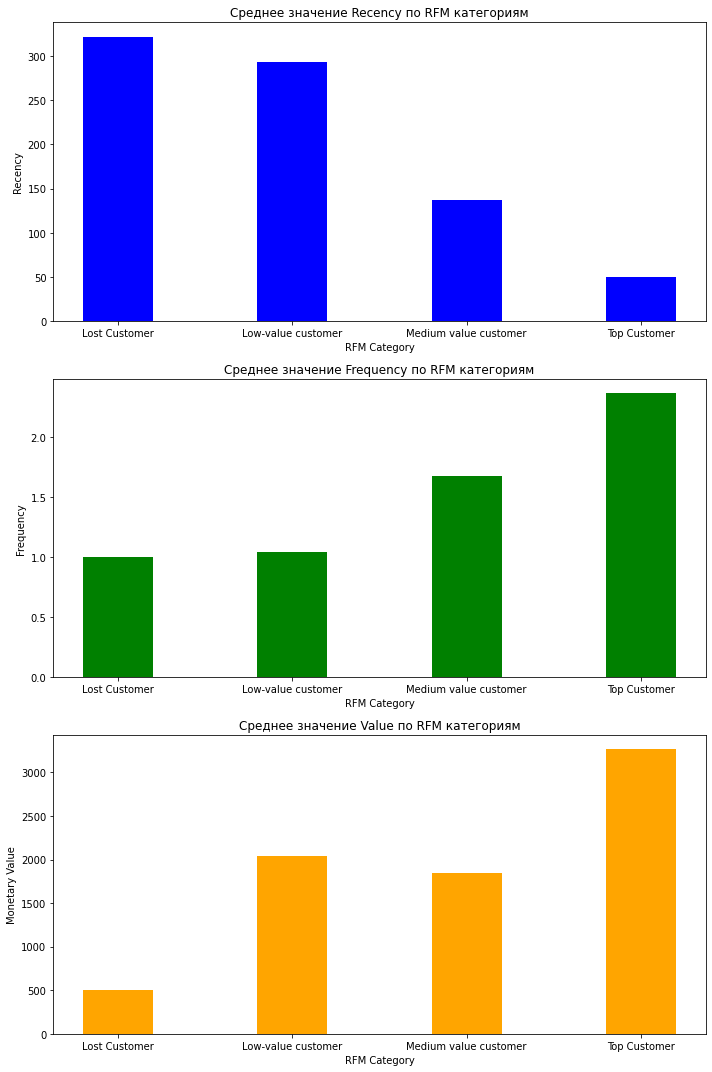

In [39]:
# Для каждой категории создаем отдельный график
fig, axes = plt.subplots(nrows=3, figsize=(10, 15))

# Данные для визуализации
categories = cluster_means.index
recency_mean = cluster_means['recency']
frequency_mean = cluster_means['frequency']
monetary_value_mean = cluster_means['monetary_value']

# Ширина столбцов
bar_width = 0.4

# Построение столбцов для Recency
axes[0].bar(categories, recency_mean, width=bar_width, color='blue')
axes[0].set_ylabel('Recency')
axes[0].set_title('Среднее значение Recency по RFM категориям')

# Построение столбцов для Frequency
axes[1].bar(categories, frequency_mean, width=bar_width, color='green')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Среднее значение Frequency по RFM категориям')

# Построение столбцов для Monetary Value
axes[2].bar(categories, monetary_value_mean, width=bar_width, color='orange')
axes[2].set_ylabel('Monetary Value')
axes[2].set_title('Среднее значение Value по RFM категориям')

# Настройка осей и меток
for ax in axes:
    ax.set_xlabel('RFM Category')

# Размещение графиков
plt.tight_layout()

# Отображение графиков
plt.show()

**Вывод:**

1. Добавлен столбец `total_price`(общая стоимость заказа цена за товар * кол-во товара) и `only_date`(дата без времени) к `df_new`
2. Дата отсчета для подсчета `Recency` - дата последнего заказа
3. Промежуток анализа - 487 дней
4. С помощью RFM анализа разбили покупателей на 4 категории:
  - `Lost Customer`
  - `Low-value customer`
  - `Medium value customer`
  - `Top Customer`
5. Итоговая таблица по кластерам

| RFM_category         | Давность    | Частота  | Денежная ценность |
|----------------------|------------|------------|----------------|
| Lost Customer        | 322 | 1.0   | 498     |
| Low-value customer   | 294 | 1.0   | 2044    |
| Medium value customer | 138 | 1.7   | 1841    |
| Top Customer         | 50  | 2.4   | 3264    |


## Проверка кластеризации с помощью статистических тестов

In [40]:
def check_normality_all_segments(RFM_segment, alpha=0.05):
    """
    Проверяет нормальность распределения для всех сегментов по среднему чеку и частоте покупок.

    Параметры:
    - RFM_segment: DataFrame с данными, включая столбцы 'RFM_category', 'monetary_value' и 'frequency'
    - alpha: уровень значимости

    Вывод:
    - Результаты теста на нормальность для каждого сегмента и параметра
    """
    categories = RFM_segment['RFM_category'].unique()

    for category in categories:
        segment_monetary = RFM_segment[RFM_segment['RFM_category'] == category]['monetary_value']
        segment_frequency = RFM_segment[RFM_segment['RFM_category'] == category]['frequency']

        print(f"Сегмент: {category}")

        print("\nСредний чек:")
        statistic_monetary, p_value_monetary = shapiro(segment_monetary)
        print("Статистика теста:", statistic_monetary)
        print("p-значение:", p_value_monetary)
        if p_value_monetary > alpha:
            print("Распределение данных не различается от нормального (не отвергаем H0).")
        else:
            print("Распределение данных статистически отличается от нормального (отвергаем H0).")

        print("\nЧастота покупок:")
        statistic_frequency, p_value_frequency = shapiro(segment_frequency)
        print("Статистика теста:", statistic_frequency)
        print("p-значение:", p_value_frequency)
        if p_value_frequency > alpha:
            print("Распределение данных не различается от нормального (не отвергаем H0).")
        else:
            print("Распределение данных статистически отличается от нормального (отвергаем H0).")

        print("=" * 50 + "\n")

check_normality_all_segments(RFM_segment)

Сегмент: Low-value customer

Средний чек:
Статистика теста: 0.4271608591079712
p-значение: 3.4032875710808405e-33
Распределение данных статистически отличается от нормального (отвергаем H0).

Частота покупок:
Статистика теста: 0.21396595239639282
p-значение: 3.045525582009476e-37
Распределение данных статистически отличается от нормального (отвергаем H0).

Сегмент: Lost Customer

Средний чек:
Статистика теста: 0.8830617070198059
p-значение: 1.534887895883687e-25
Распределение данных статистически отличается от нормального (отвергаем H0).

Частота покупок:
Статистика теста: 0.04581981897354126
p-значение: 0.0
Распределение данных статистически отличается от нормального (отвергаем H0).

Сегмент: Medium value customer

Средний чек:
Статистика теста: 0.31167536973953247
p-значение: 2.802596928649634e-45
Распределение данных статистически отличается от нормального (отвергаем H0).

Частота покупок:
Статистика теста: 0.18842929601669312
p-значение: 0.0
Распределение данных статистически отлич

Гипотеза H0 (нулевая гипотеза) для среднего чека:

    H0: Нет статистически значимой разницы в среднем чеке между двумя кластерами (сегментами).
Гипотеза H1 (альтернативная гипотеза) для среднего чека:

    H1: Существует статистически значимая разница в среднем чеке между двумя кластерами (сегментами).
Гипотеза H0 для частоты покупок:

    H0: Нет статистически значимой разницы в частоте покупок между двумя кластерами (сегментами).
Гипотеза H1 для частоты покупок:

    H1: Существует статистически значимая разница в частоте покупок между двумя кластерами (сегментами).

In [41]:
def mann_whitney_u_test_between_clusters(segment1, segment2, alpha=0.05):
    """
    Проводит тест Манна-Уитни между двумя кластерами.

    Параметры:
    - segment1: первый сегмент
    - segment2: второй сегмент
    - alpha: уровень значимости

    Вывод:
    - Результаты теста Манна-Уитни для среднего чека и частоты покупок
    """
    segment1_monetary = RFM_segment[RFM_segment['RFM_category'] == segment1]['monetary_value']
    segment2_monetary = RFM_segment[RFM_segment['RFM_category'] == segment2]['monetary_value']

    segment1_frequency = RFM_segment[RFM_segment['RFM_category'] == segment1]['frequency']
    segment2_frequency = RFM_segment[RFM_segment['RFM_category'] == segment2]['frequency']

    # Проведение теста Манна-Уитни для среднего чека
    u_statistic_monetary, p_value_monetary = mannwhitneyu(segment1_monetary, segment2_monetary)

    # Проведение теста Манна-Уитни для частоты покупок
    u_statistic_frequency, p_value_frequency = mannwhitneyu(segment1_frequency, segment2_frequency)

    # Вывод результатов
    print("Средний чек:")
    print("U-статистика:", u_statistic_monetary)
    print("p-значение:", p_value_monetary)

    # Формулировка гипотез
    h0_monetary = f"Нет статистически значимой разницы в среднем чеке между сегментами {segment1} и {segment2}."
    h1_monetary = f"Существует статистически значимая разница в среднем чеке между сегментами {segment1} и {segment2}."

    if p_value_monetary < alpha:
        print("Различия между средними значениями статистически значимы.")
        print("Отвергаем нулевую гипотезу:", h1_monetary)
    else:
        print("Нет статистически значимых различий между средними значениями.")
        print("Принимаем нулевую гипотезу:", h0_monetary)

    print("\nЧастота покупок:")
    print("U-статистика:", u_statistic_frequency)
    print("p-значение:", p_value_frequency)

    # Формулировка гипотез
    h0_frequency = f"Нет статистически значимой разницы в частоте покупок между сегментами {segment1} и {segment2}."
    h1_frequency = f"Существует статистически значимая разница в частоте покупок между сегментами {segment1} и {segment2}."

    if p_value_frequency < alpha:
        print("Различия между средними значениями статистически значимы.")
        print("Отвергаем нулевую гипотезу:", h1_frequency)
    else:
        print("Нет статистически значимых различий между средними значениями.")
        print("Принимаем нулевую гипотезу:", h0_frequency)

In [42]:
def u_test_between_clusters_all_pairs(alpha=0.05):
    """
    Вызывает mann_whitney_u_test_between_clusters для всех уникальных пар категорий.

    Параметры:
    - alpha: уровень значимости

    Вывод:
    - Результаты u-теста для среднего чека и частоты покупок для всех пар категорий
    """
    categories = RFM_segment['RFM_category'].unique()

    for i in range(len(categories)):
        for j in range(i + 1, len(categories)):
            segment1 = categories[i]
            segment2 = categories[j]

            print(f"Сравнение между {segment1} и {segment2}:")
            mann_whitney_u_test_between_clusters(segment1, segment2, alpha)
            print("\n" + "="*50 + "\n")
u_test_between_clusters_all_pairs()

Сравнение между Low-value customer и Lost Customer:
Средний чек:
U-статистика: 296468.5
p-значение: 3.230847520171277e-88
Различия между средними значениями статистически значимы.
Отвергаем нулевую гипотезу: Существует статистически значимая разница в среднем чеке между сегментами Low-value customer и Lost Customer.

Частота покупок:
U-статистика: 181643.0
p-значение: 3.291521959719247e-07
Различия между средними значениями статистически значимы.
Отвергаем нулевую гипотезу: Существует статистически значимая разница в частоте покупок между сегментами Low-value customer и Lost Customer.


Сравнение между Low-value customer и Medium value customer:
Средний чек:
U-статистика: 154972.5
p-значение: 0.000397128060041599
Различия между средними значениями статистически значимы.
Отвергаем нулевую гипотезу: Существует статистически значимая разница в среднем чеке между сегментами Low-value customer и Medium value customer.

Частота покупок:
U-статистика: 59725.0
p-значение: 6.964776079161616e-73

**Вывод:**

1. Таким образом оба u-теста нашли различия между кластерами. Разбиение корректно

## Анализ сегментов и рекомендации

In [43]:
# Добавим RFM сегменты в df_new
RFM_segment_reset_index = RFM_segment.reset_index()
df_new = pd.merge(df_new, RFM_segment_reset_index[['customer_id', 'RFM_category']], on='customer_id', how='left')
df_new.sample(5)

,date,customer_id,order_id,product,quantity,price,category,only_date,total_price,RFM_category
4835,2019-10-31 12:00:00,1f0a7f35-7459-4f23-b468-5e45bf481dd1,73158,Сумка-тележка 2-х колесная Gimi Argo синяя,1,1087.0,Товары для хранения и организации,2019-10-31,1087.0,Medium value customer
1294,2019-01-16 11:00:00,f420bf6d-9985-47bc-95a7-5c640ad6d001,69842,Муляж Зеленое яблоко полиуретан d-6 см,1,22.0,Искусственные цветы и растения,2019-01-16,22.0,Lost Customer
1222,2019-01-03 09:00:00,ba6b1c8e-1108-467a-84cb-ac32c576e399,69696,Сушилка для белья настенная Zalger Prima 510-7...,1,299.0,Товары для ванной комнаты,2019-01-03,299.0,Lost Customer
1898,2019-03-06 17:00:00,8d121b21-0ee3-4e88-ab84-56486bc98479,70639,Сумка-тележка 2-х колесная Gimi Argo фиолетовая,1,1087.0,Товары для хранения и организации,2019-03-06,1087.0,Low-value customer
1419,2019-02-03 16:00:00,0a1b82ed-6fa9-486b-b358-4746f82f6e77,70075,"Крючок проволочный 75 мм латунь, 1110136",1,44.0,Товары для хранения и организации,2019-02-03,44.0,Medium value customer


In [44]:
# Создадим таблицу, где каждому order_id соответствует общая сумма заказа, категория RFM_category и дата заказа
df_group = df_new.df_group = df_new.groupby('order_id').agg({'total_price': lambda x: x.sum()}).reset_index()
df_group = pd.merge(df_group, df_new[['order_id', 'RFM_category', 'only_date']], on='order_id', how='left')
# Преобразуем столбец в формат datetime
df_group['only_date'] = pd.to_datetime(df_group['only_date'])
# Округляем до месяца
df_group['only_date'] = df_group['only_date'].dt.to_period('M')
df_group.head(5)

/tmp/ipykernel_194/619418114.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_group = df_new.df_group = df_new.groupby('order_id').agg({'total_price': lambda x: x.sum()}).reset_index()


,order_id,total_price,RFM_category,only_date
0,12624,375.0,Lost Customer,2019-06
1,12624,375.0,Lost Customer,2019-06
2,13547,684.0,Lost Customer,2018-11
3,13547,684.0,Lost Customer,2018-11
4,13547,684.0,Lost Customer,2018-11


<Figure size 1008x720 with 0 Axes>

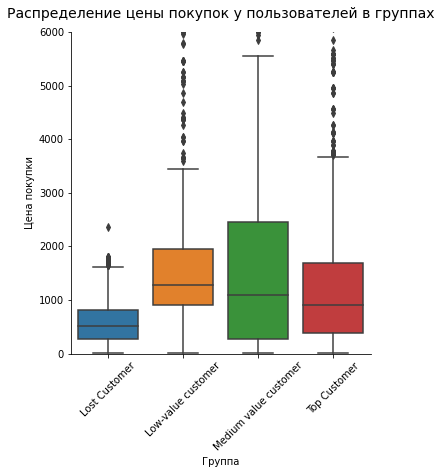

In [45]:
# Построим график catplot
plt.figure(figsize=(14, 10))
sns.catplot(data=df_group, x="RFM_category", y="total_price", kind="box")
plt.ylim(0, 6000)
plt.xticks(rotation=45, fontsize=10)
plt.xlabel('Группа', fontsize=10)
plt.ylabel('Цена покупки', fontsize=10)
plt.title('Распределение цены покупок у пользователей в группах', pad=14, fontsize=14)
plt.show()

Далее отдельно проведем анализ кластеров

In [46]:
def vis_clasters_combined(claster):
    """
    Визуализирует графики зависимости % проданных товаров и % суммы продаж от даты для разных категорий

    Параметры:
    - claster: Кластер покупателей
    """
    df_new_claster = df_new.query('RFM_category == @claster').copy()
    df_new_claster['only_date'] = pd.to_datetime(df_new_claster['only_date']).copy()
    df_new_claster['only_date'] = df_new_claster['only_date'].dt.to_period('M').copy()
    sns.set_theme(style="darkgrid")

    # Увеличиваем размер графика
    fig, axes = plt.subplots(nrows=len(df_new_claster['category'].unique()), ncols=2, figsize=(12, 6*len(df_new_claster['category'].unique())), sharex=False, sharey=False, gridspec_kw={'hspace': 0.5})

    # Проходим по каждой категории и строим графики на соответствующих подграфиках
    for i, category in enumerate(df_new_claster['category'].unique()):

        # Индивидуальные цвета для каждой категории
        color = sns.color_palette('husl', n_colors=len(df_new_claster['category'].unique()))[i]

        # График для цены
        df_cycle_price = df_new_claster[df_new_claster['category'] == category].copy()
        df_cycle_price['price_percent'] = (df_cycle_price['total_price'] / df_cycle_price['total_price'].sum()) * 100
        sns.barplot(x="only_date", y="price_percent",
                     data=df_cycle_price,
                     ax=axes[i, 0], label=category, color=color, estimator=sum)
        axes[i, 0].set_xlabel('Дата', fontsize=8)
        axes[i, 0].set_ylabel('% от общих продаж по категории', fontsize=8)
        axes[i, 0].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i, 0].set_title(category, x=1.09 ,y=1.02)
        axes[i, 0].legend().set_visible(False)

        # График для количества товаров
        df_cycle_quantity = df_new_claster[df_new_claster['category'] == category].copy()
        df_cycle_quantity['quantity_percent'] = (df_cycle_quantity['quantity'] / df_cycle_quantity['quantity'].sum()) * 100
        sns.barplot(x="only_date", y="quantity_percent",
                     data=df_cycle_quantity,
                     ax=axes[i, 1], estimator=sum, label=category, color=color)
        axes[i, 1].set_xlabel('Дата', fontsize=8)
        axes[i, 1].set_ylabel('% купленных товаров', fontsize=8)
        axes[i, 1].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i, 1].legend().set_visible(False)

        # Проводим вертикальные линии для границ сезонов
        axes[i, 0].axvline(x=1.5, color='gray', linestyle='--', linewidth=1)  # Граница зимы и весны
        axes[i, 1].axvline(x=1.5, color='gray', linestyle='--', linewidth=1)

        axes[i, 0].axvline(x=4.5, color='gray', linestyle='--', linewidth=1)  # Граница весны и лета
        axes[i, 1].axvline(x=4.5, color='gray', linestyle='--', linewidth=1)

        axes[i, 0].axvline(x=7.5, color='gray', linestyle='--', linewidth=1)  # Граница лета и осени
        axes[i, 1].axvline(x=7.5, color='gray', linestyle='--', linewidth=1)

        axes[i, 0].axvline(x=10.5, color='gray', linestyle='--', linewidth=1)  # Граница осени и зимы
        axes[i, 1].axvline(x=10.5, color='gray', linestyle='--', linewidth=1)

    # Общее название графика
    fig.suptitle("Графики зависимости % проданных товаров и % суммы продаж от даты\nдля разных категорий", fontsize=16, y=0.9)

    plt.show()



In [47]:
def vis_category_combined(cluster):
    """
    Визуализирует графики зависимости % проданных товаров и % суммы продаж от категории для указанного кластера

    Параметры:
    - cluster: Кластер покупателей
    """
    df_new_cluster = df_new[df_new['RFM_category'] == cluster].copy()
    df_new_cluster['only_date'] = pd.to_datetime(df_new_cluster['only_date'])
    df_new_cluster['only_date'] = df_new_cluster['only_date'].dt.to_period('M')
    sns.set_theme(style="darkgrid")

    # Увеличиваем размер графика
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

    # График для % от продаж по категории
    df_price_percent = df_new_cluster.groupby('category')['total_price'].sum() / df_new_cluster['total_price'].sum() * 100
    df_price_percent = df_price_percent.sort_values(ascending=False)
    price_plot = sns.barplot(x=df_price_percent.index, y=df_price_percent, ax=axes[0])

    for idx, value in enumerate(df_price_percent):
        price_plot.text(idx, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=12)

    # Добавляем легенду для первого графика
    legend_labels_price = {category: color for category, color in zip(df_price_percent.index, price_plot.patches)}
    axes[0].legend(handles=legend_labels_price.values(), labels=legend_labels_price.keys(), title='Категория', title_fontsize='14', fontsize='12')

    axes[0].set_xlabel('Категория', fontsize=12)
    axes[0].set_ylabel('% от общих продаж по категории', fontsize=12)
    axes[0].set_xticklabels([])
    axes[0].set_title(f'Процент от продаж по категориям для кластера {cluster}', fontsize=14)

    # График для % от количества по категории
    df_quantity_percent = df_new_cluster.groupby('category')['quantity'].sum() / df_new_cluster['quantity'].sum() * 100
    df_quantity_percent = df_quantity_percent.sort_values(ascending=False)
    quantity_plot = sns.barplot(x=df_quantity_percent.index, y=df_quantity_percent, ax=axes[1])

    for idx, value in enumerate(df_quantity_percent):
        quantity_plot.text(idx, value + 1, f'{value:.2f}%', ha='center', va='bottom', fontsize=12)

    # Добавляем легенду для второго графика
    legend_labels_quantity = {category: color for category, color in zip(df_quantity_percent.index, quantity_plot.patches)}
    axes[1].legend(handles=legend_labels_quantity.values(), labels=legend_labels_quantity.keys(), title='Категория', title_fontsize='14', fontsize='12')

    axes[1].set_xlabel('Категория', fontsize=12)
    axes[1].set_ylabel('% купленных товаров по категории', fontsize=12)
    axes[1].set_xticklabels([])
    axes[1].set_title(f'Процент от количества проданного товара по категориям для кластера {cluster}', fontsize=14)

    plt.tight_layout()
    plt.show()

**Вывод:**
1. Видно, что медианное значение суммы заказа категории `Lost Customer` меньше, чем у остальных категорий
2. Самое высокое значение у категории `Low-value customer`, хотя не сильно выше чем у отсальных 2 категорий
3. В таблицу df_new добавлены RFM сегменты
4. Создана функция vis_clasters_combined, которая визуализирует графики зависимости % проданных товаров и % суммы продаж от даты для разных категорий и vis_category_combined, которая визуализирует графики зависимости % проданных товаров и % суммы продаж от категории для указанного кластера


### Lost Customer

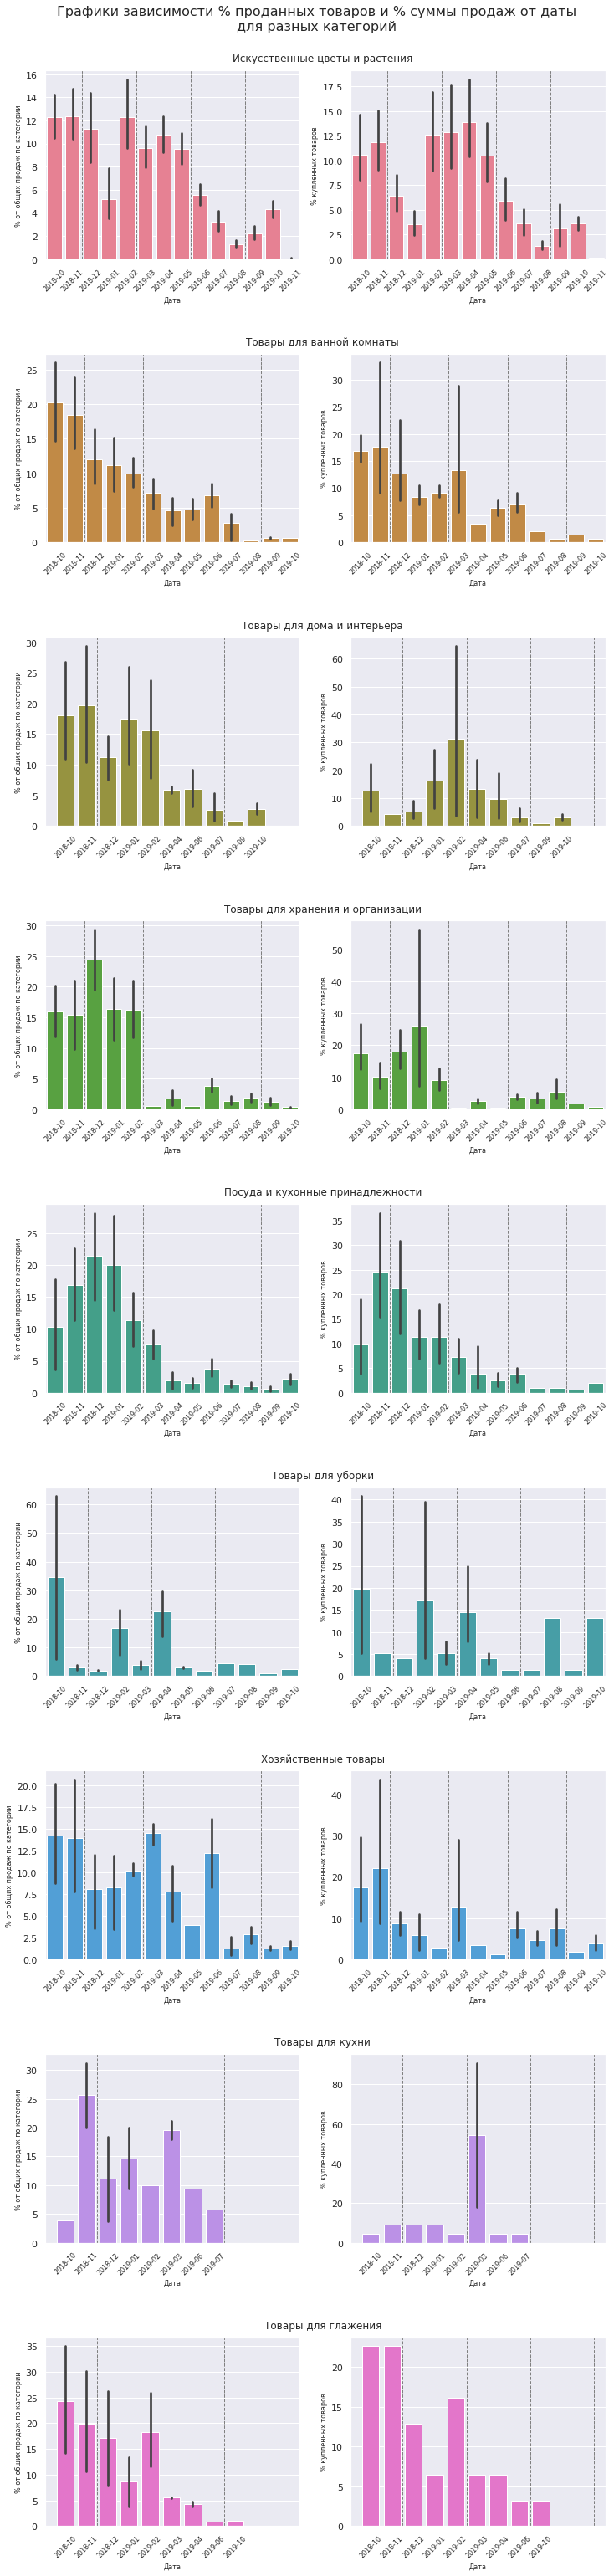

In [48]:
vis_clasters_combined('Lost Customer')

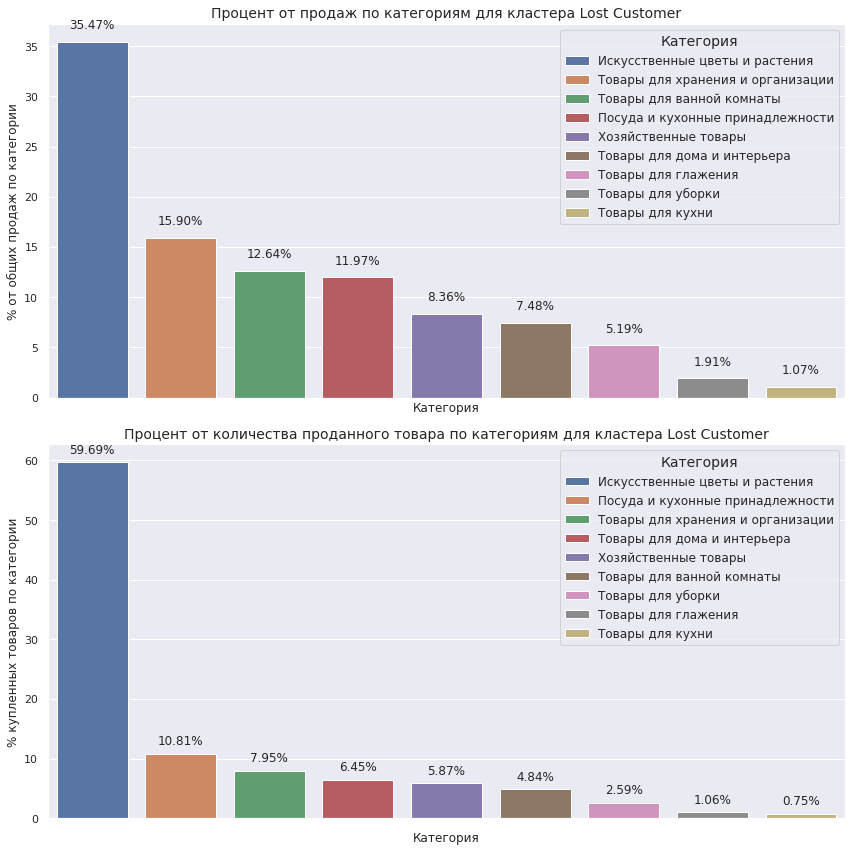

In [49]:
vis_category_combined('Lost Customer')

**Вывод:**
1. `Искусственные цветы и растения`. Достаточно хаотичный график. Падает в июне 2019 года
2. `Товары для ванной комнаты`
  - хорошие показатели осенью/зимой 2018/2019, затем сильное снижение интереса покупателя
3. `Товары для дома и интерьера`
  - наиболее высокая активность зимой 2019 года, затем падаение
4. `Товары для хранения и организации`
  - хорошие показатели осенью/зимой 2018/2019, затем сильное снижение
5. `Посуда и кухонные принадлежности` пиковые значения в:
  - хорошие показатели осенью/зимой 2018/2019, затем сильное снижение
6. `Товары для уборки` наибольшая активность в:
  - октябре 2018
  - марте 2019
  - апреле 2019
7. `Хозяйственные товары`
  - высокая активность в начале сезонов, но в целом график убывает линейно
8. `Товары для кухни` пиковые значения в:
  - товары полностью перестали покупать после июля 2019
  - хорошим месяцем остается март 2019 и ноябрь 2018
9. `Товары для глажения`
  - хорошие показатели осенью/зимой 2018/2019, затем сильное снижение интереса покупателя



**Вывод:**
1. Таким образом для кластера `Lost Customer` рекомендованно рассылать рекламные рассылки по категориям:
  - `Искусственные цветы и растения` летом и осенью
  - `Посуда и кухонные принадлежности` зимой
  - `Товары для дома и интерьера` зимой
  - `Товары для уборки` весной
  - `Товары для ванной комнаты` осень/зима
  - `Товары для хранения и организации` осень/зима
  - `Хозяйственные товары` в начале сезона(в сособенности весна)в
  - `Товары для кухни` в начале весны
  - `Товары для глажения` осень/зима
2. Товары для хранения и организации(15.9%) и искусственные цветы и растения(35.47%) в сумме забирают на себя 50% потраченных покупателями средств. Но чаще всего покупают искусственные цветы и растения(59.69%), затем идет посуда и кухонные принадлежности(10.81%)
3. В целом кластер малоплатежеспособный и рекламная компания может не окупиться

### Low-value customer

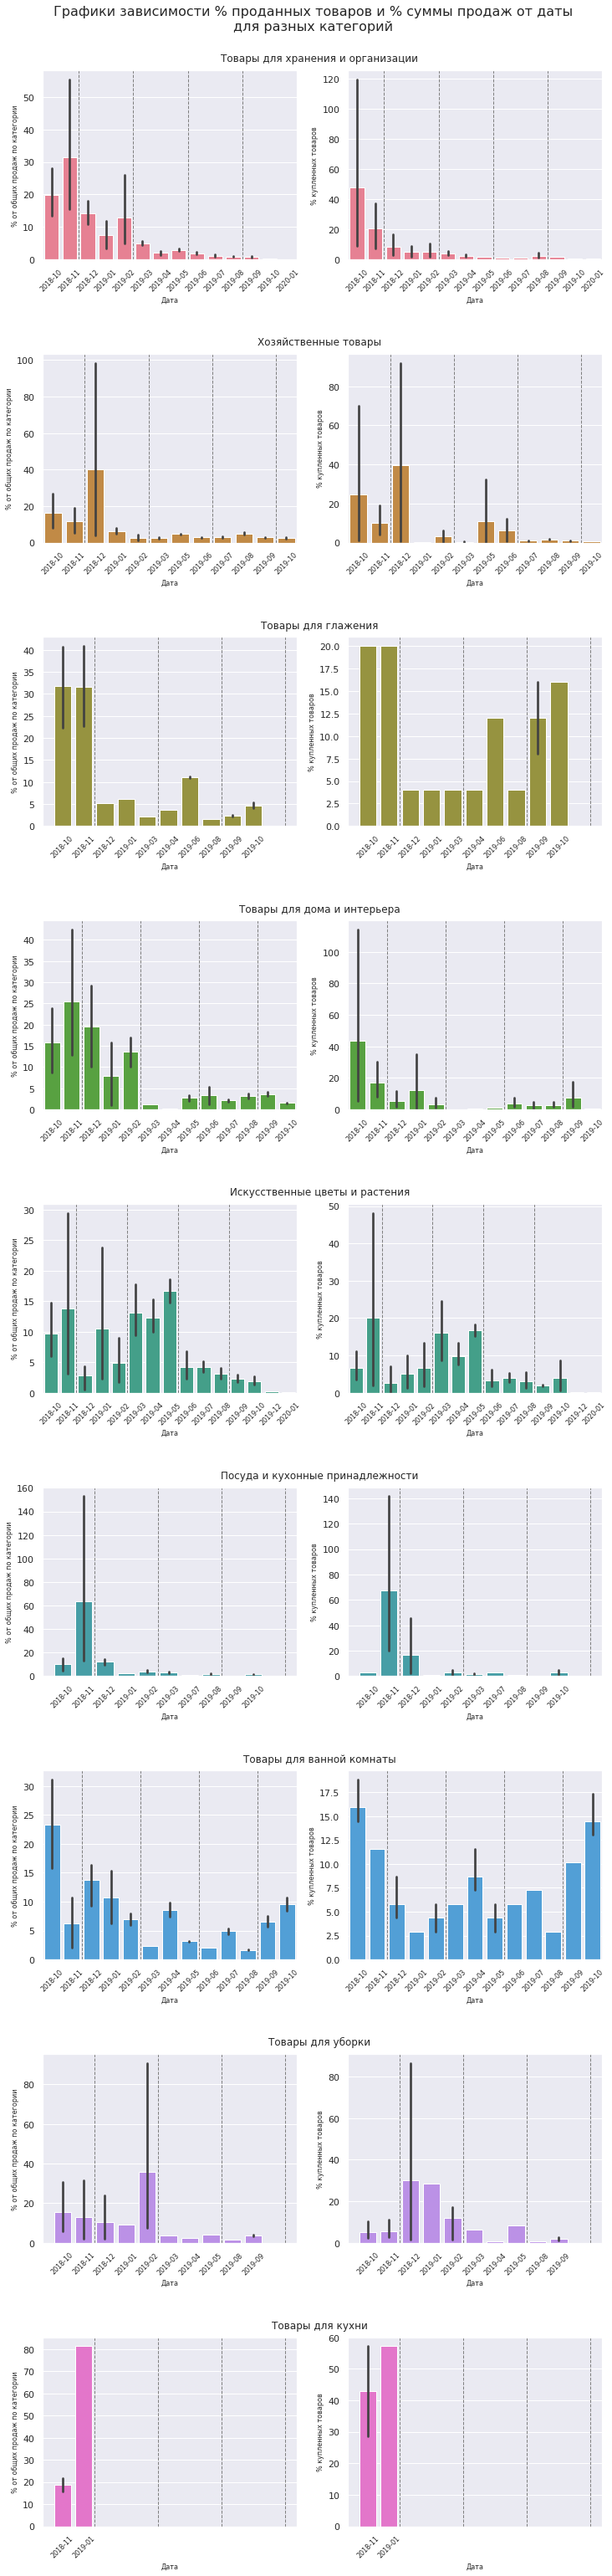

In [50]:
vis_clasters_combined('Low-value customer')

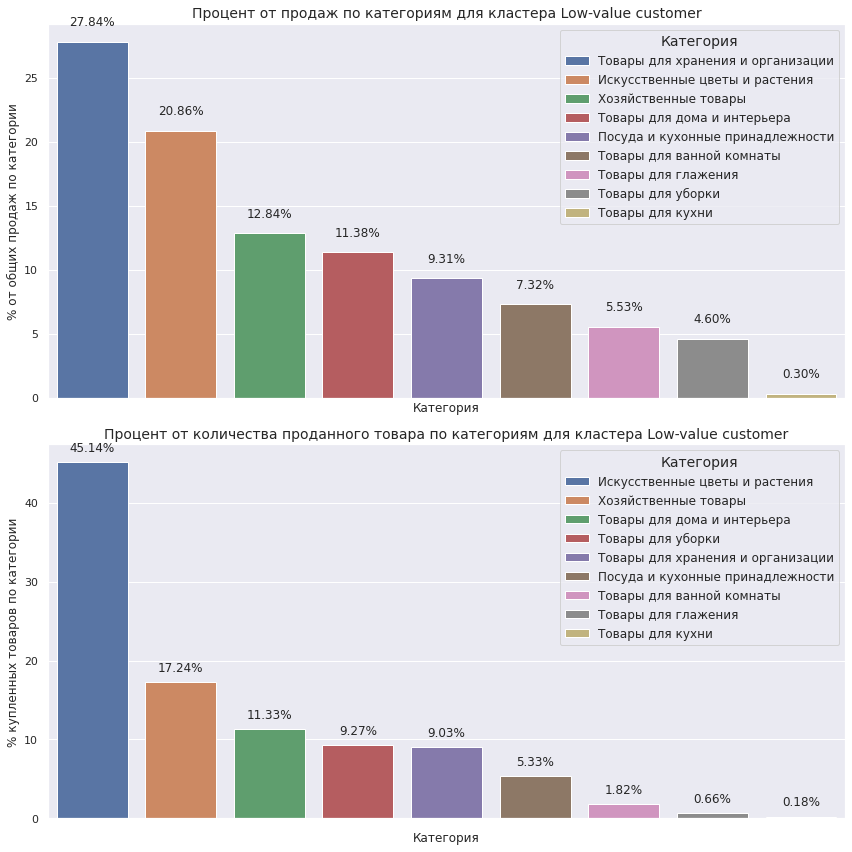

In [51]:
vis_category_combined('Low-value customer')

**Вывод:**
1. `Искусственные цветы и растения`
  - лето 2019 самый активный месяц
1. `Посуда и кухонные принадлежности`
  - в основном покупали только в ноябре 2018
1. `Товары для дома и интерьера`
  - высокие показатели осенью/зимой 2018/2019
  - активность упала до минимума и начала расти осенью 2019, но с заметно меньшей стоимостью товаров
1. `Товары для уборки`
  - зима 2019 самый активный месяц
1. `Товары для ванной комнаты`
  - покупают всегда, за исключением малой активности весны и лета 2019
1. `Товары для хранения и организации` степенное уменьшение графиков с самого начала анализа(осени 2018)
1. `Хозяйственные товары`
  - декабрь 2018, апрель и май 2019 бли наиболее активными месяцами
1. `Товары для кухни`
  - совсем перестали покупать после января 2019
1. `Товары для глажения`
  - осенью 2018 покупали много и дорого
  - до осени 2019 нет активности
  - осенью 2019 стали покупать много, но уже не такие дорогие товары


**Вывод:**
1. Таким образом для кластера `Low-value customer` рекомендованно рассылать рекламные рассылки по категориям:
  - `Искусственные цветы и растения` летом
  - `Посуда и кухонные принадлежности` в начале ноября
  - `Товары для дома и интерьера` осенью/зимой
  - `Товары для уборки` зимой
  - `Товары для ванной комнаты` осенью/зимой
  - `Товары для хранения и организации` осень
  - `Хозяйственные товары` в начале сезона(в сособенности весна)
  - `Товары для глажения` осенью
3. Товары для хранения и организации(20.86%) и искусственные цветы и растения(27.84%) в сумме забирают на себя 60% потраченных покупателями средств. Но чаще всего покупают искусственные цветы и растения(45.14%), затем идут хоз. товары(17.24%)
2. Сегмент хорошо платит, стоит рассмотреть возможность привлечения покупателей этого сегмента

### Medium value customer

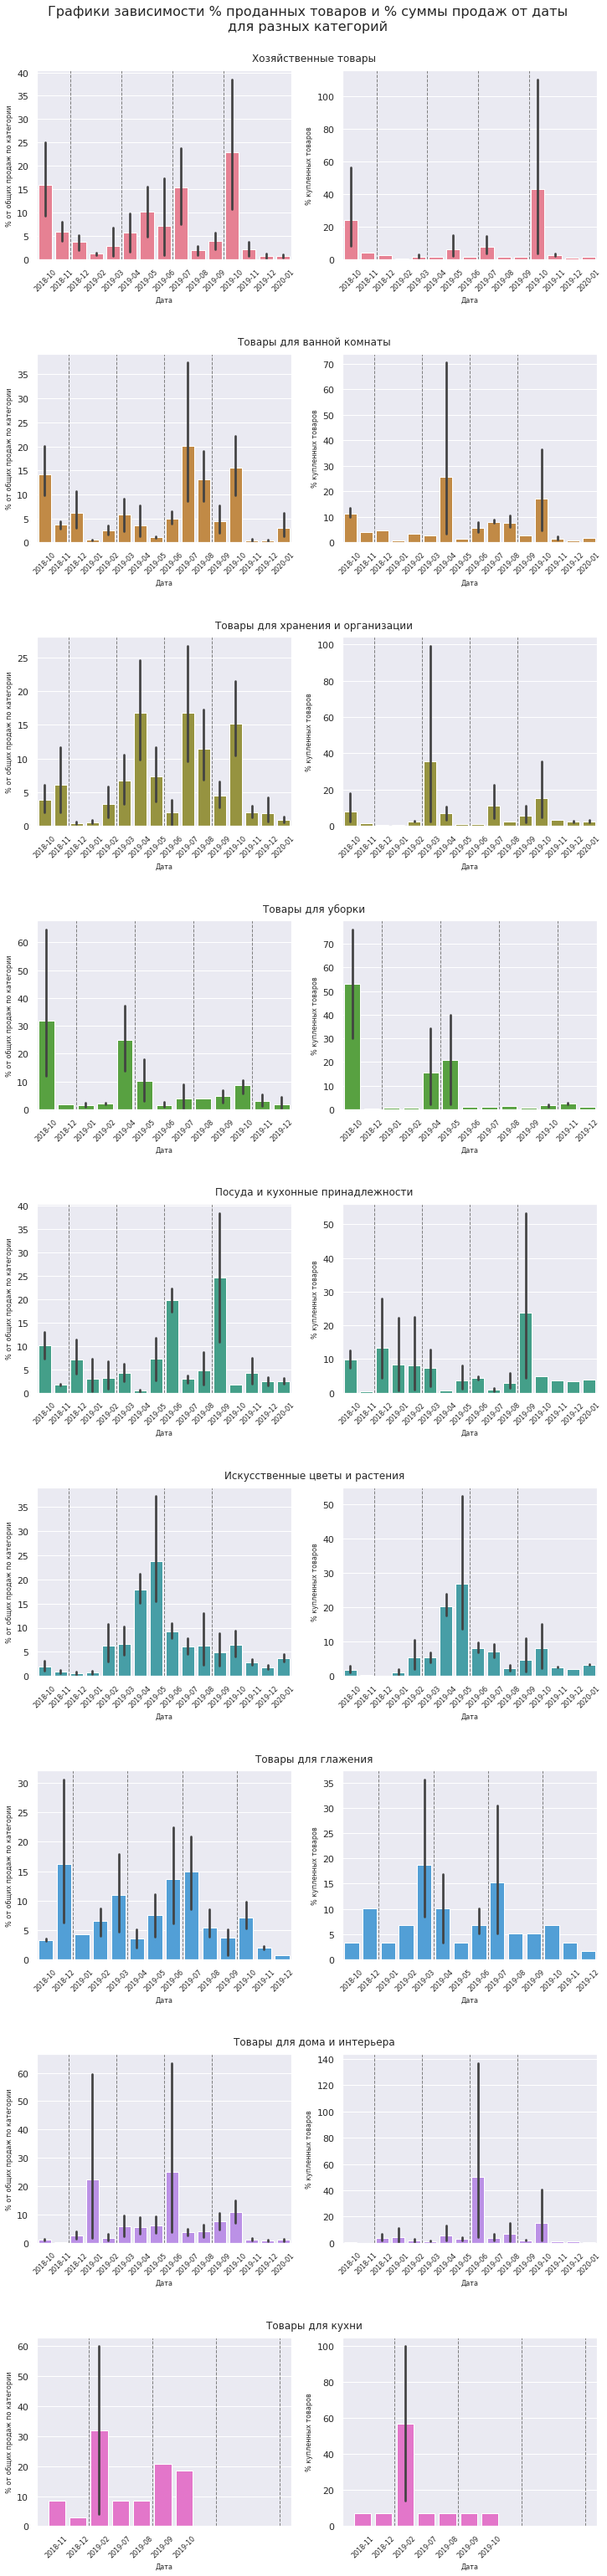

In [52]:
vis_clasters_combined('Medium value customer')

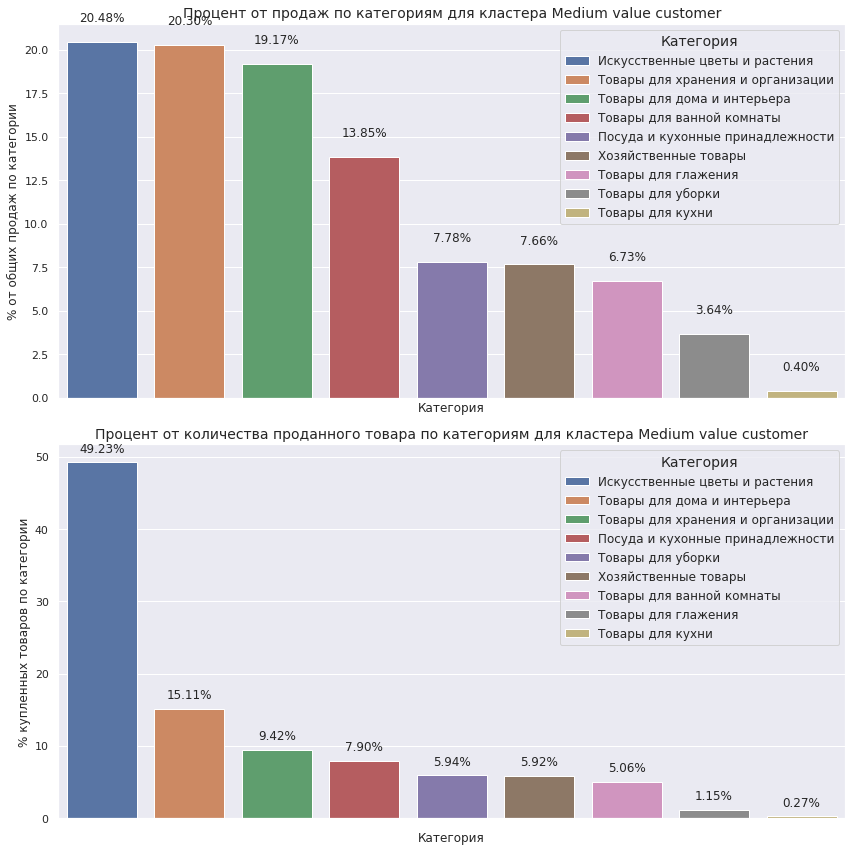

In [53]:
vis_category_combined('Medium value customer')

**Вывод:**
1. `Искусственные цветы и растения`
  - весна и лето 2019 - самые активные сезоны
1. `Посуда и кухонные принадлежности`
  - в особенности выделяется июнь и сентябрь 2019
1. `Товары для дома и интерьера`, в особенности выделяются:
  - январь 2019
  - октябрь 2019
1. `Товары для уборки`
  - октябрь 2018, апрель и май 2019 наиболее активные месяцы
1. `Товары для ванной комнаты`
  - лето и осень наиболее активные сезоны
1. `Товары для хранения и организации`
  - весна, конец лета и осень наиболее активные сезоны
1. `Хозяйственные товары`
  - самый прибыльный месяц- октябрь
  - хорошие продажи в конце весны и начале лета
1. `Товары для кухни`, в особенности выделяются:
  - февраль, сентябрь октябрь 2019
1. `Товары для глажения`, в особенности выделяются:
  - декабрь 2018
  - март 2019
  - июнь-июль 2019


**Вывод:**
1. Таким образом для кластера `Medium value customer` рекомендованно рассылать рекламные рассылки по категориям:
  - `Искусственные цветы и растения` весной/летом
  - `Посуда и кухонные принадлежности` июнь, сентябрь
  - `Товары для дома и интерьера` январе, октябре
  - `Товары для уборки` весной
  - `Товары для ванной комнаты` летом/осенью
  - `Товары для хранения и организации` весной, конец лета и осенью
  - `Хозяйственные товары` в октябре, в начале лета
  - `Товары для кухни` осенью
  - `Товары для глажения` в декабре, маре, июне-июле
2. Товары для хранения и организации, искусственные цветы и растения и товары для дома и интерьера в сумме и примерно равными частями забирают на себя 60% потраченных покупателями средств. Но чаще всего покупают искусственные цветы и растения(49.23%) 
3. Сегмент хорошо платит, стоит рассмотреть возможность привлечения покупателей этого сегмента

### Top Customer

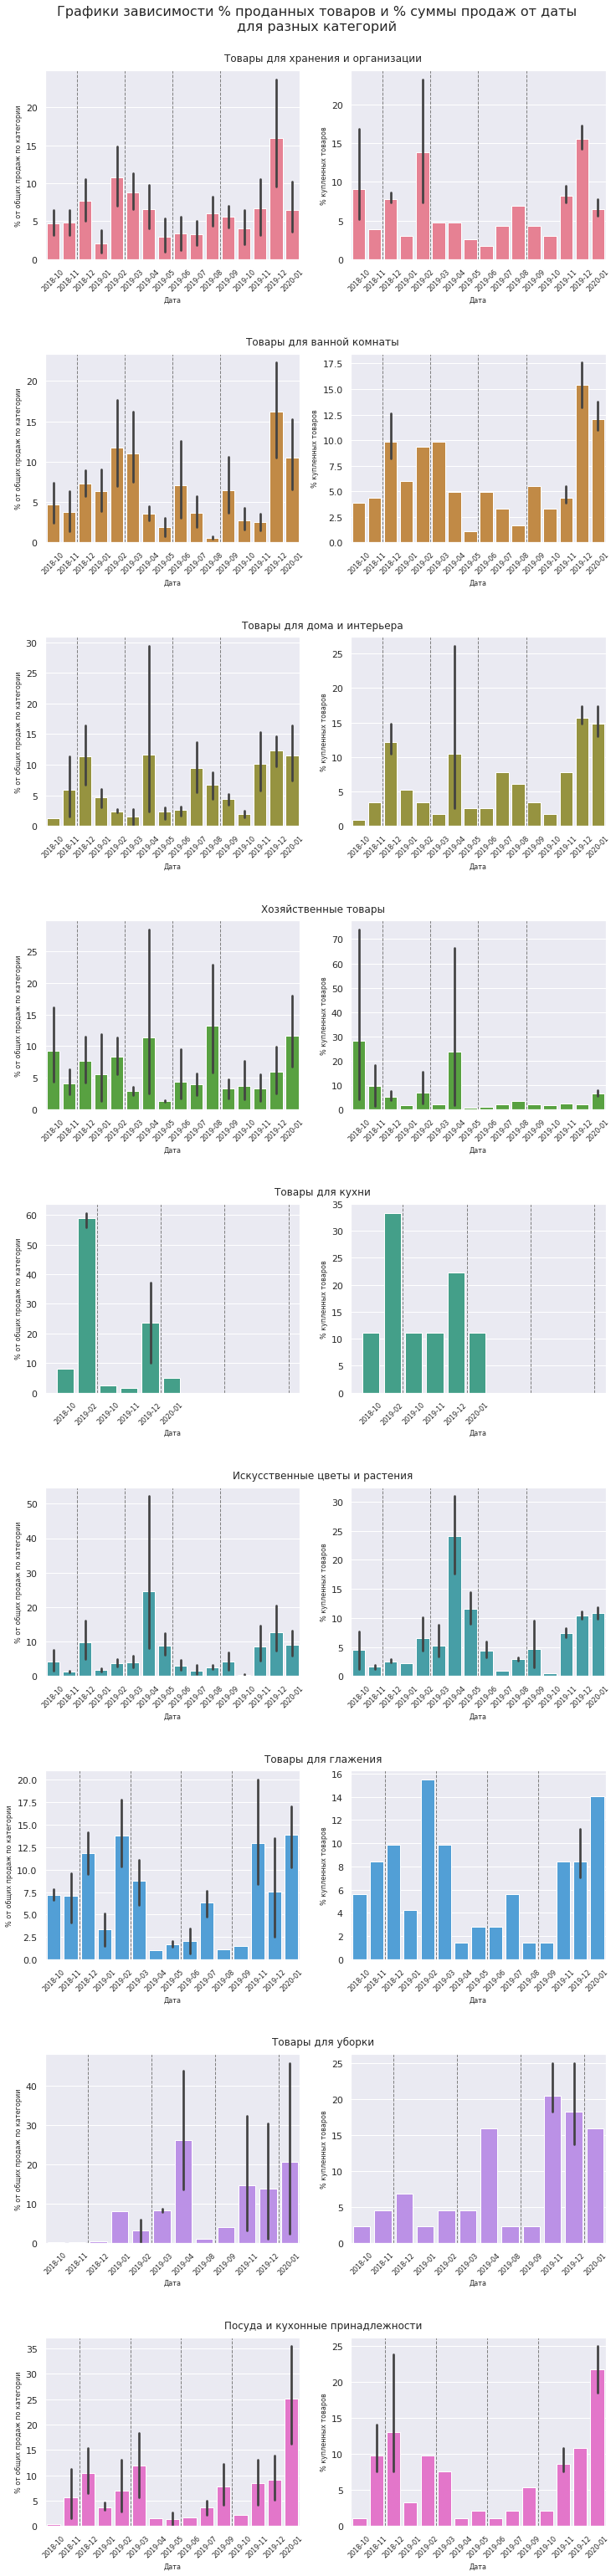

In [54]:
vis_clasters_combined('Top Customer')

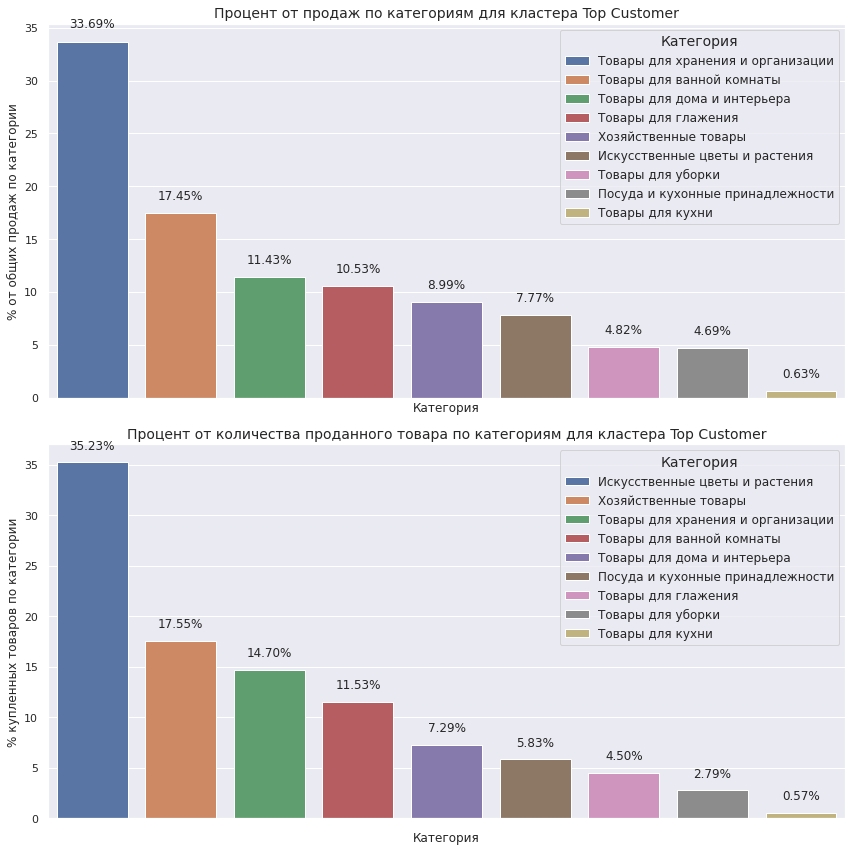

In [55]:
vis_category_combined('Top Customer')

**Вывод:**
1. `Искусственные цветы и растения`
  - наибольшая активность весной и зимой
1. `Посуда и кухонные принадлежности`
  - активность зимой 2020
1. `Товары для дома и интерьера`
  - зима и середина каждого сезона набирают наибольшую активность
1. `Товары для уборки`
  - активность в конце осени и начале зимы
1. `Товары для ванной комнаты`
  - самый активный сезон - зима
1. `Товары для хранения и организации`
  - наибольшая активность зимой
1. `Хозяйственные товары`
  - хаотичные изменения, видна тенденция к покупке реже но более дорогих товаров
1. `Товары для кухни`
  - активность в феврале 2019
1. `Товары для глажения`
  - наибольшая активность зимой и в конце осени


**Вывод:**
1. Таким образом для кластера `Top Customer` рекомендованно рассылать рекламные рассылки по категориям:
  - `Искусственные цветы и растения` весной/зимой
  - `Посуда и кухонные принадлежности` зимой
  - `Товары для дома и интерьера` зимой
  - `Товары для уборки` конец осени и начало зимы
  - `Товары для ванной комнаты` зимой
  - `Товары для хранения и организации` зимой
  - `Товары для кухни` феврале
  - `Товары для глажения` конец осени/зима
2. Товары для хранения и организации забирают на себя 33.7% потраченных покупателями средств. Но чаще всего покупают искусственные цветы и растения(35.23%)
3. Сегмент хорошо платит, стоит рассмотреть возможность привлечения покупателей этого сегмента

### Общий вывод

Рекомендации по проведению рекламной компании

| Категория \ Кластер       | Lost Customer               | Low-value customer        | Medium value customer     | Top Customer               |
|---------------------------|-----------------------------|---------------------------|---------------------------|-----------------------------|
| Искусственные цветы и растения | летом и осенью               | летом                     | весной/летом               | весной/зимой               |
| Посуда и кухонные принадлежности | зимой                      | в начале ноября            | июнь, сентябрь             | зимой                       |
| Товары для дома и интерьера | зимой                        | осенью/зимой               | январе, октябре            | зимой                       |
| Товары для уборки          | весной                       | зимой                     | весной                     | конец осени и начало зимы  |
| Товары для ванной комнаты  | осень/зима                   | осенью/зимой               | летом/осенью               | зимой                       |
| Товары для хранения и организации | осень/зима             | осень                      | весной, конец лета и осенью | в зимой                   |
| Хозяйственные товары       | в начале сезона (особенно весной) | в начале сезона (весной) | в октябре, в начале лета   | в начале сезона (весной)  |
| Товары для кухни           | в начале весны               |                           | осенью                     | феврале                     |
| Товары для глажения        | осень/зима                   | осенью                    | в декабре, марте, июне-июле | конец осени/зима            |


## Вывод

1. **Изучение общей информации**
  - Типы данных соответствуют ожидаемому, кроме столбца `date`
  - Перевели столбец `date` к типу datetime
2. **Подготовка и предобработка данных**
  - Ошибок в названии столбцов не обнаружено
  - Явных дубликатов не обнаружено
  - Пропусков не обнаружено
  - Дубликаты в разрезе без времени : видны различные дубликаты одного и того же заказа. Оставим последний результат, как итоговое решение покупателя.(25% дубликатов)
  - Создадим отдельный столбец `category` с категориями товаров
  - Можно сделать вывод в сторону выброса в заказах с более чем 150 позиций. Таких заказов достаточно мало(0.14%) и их можно смело удалить
  - В стобце `price` аномалий не обнаружено. Все цены лежат в допустимых значениях.
3. **RFM-анализ**
  - Добавлен столбец `total_price`(общая стоимость заказа цена за товар * кол-во товара) и `only_date`(дата без времени) к `df_new`
  - Дата отсчета для подсчета `Recency` - дата последнего заказа
  - Промежуток анализа - 487 дней
  - С помощью RFM анализа разбили покупателей на 4 категории:
    - `Lost Customer`
    - `Low-value customer`
    - `Medium value customer`
    - `Top Customer`
    - Итоговая таблица по кластерам

| RFM_category         | Давность    | Частота  | Денежная ценность |
|----------------------|------------|------------|----------------|
| Lost Customer        | 322 | 1.0   | 498     |
| Low-value customer   | 294 | 1.0   | 2044    |
| Medium value customer | 138 | 1.7   | 1841    |
| Top Customer         | 50  | 2.4   | 3264    |

4. **Проверка кластеризации с помощью статистических тестов**
  - Таким образом оба u-теста нашли различия между кластерами. Разбиение выполнено корректно.
5. **Рекомендации по проведению рекламной компании**
    1. **Сегмент `Lost Customer` (приведены средние значения по сегменту):**

        | RFM_category     | Давность | Частота | Денежная ценность |
        |------------------|----------|---------|-------------------|
        | Lost Customer    | 322      | 1.0     | 498               |

        - **Давность:** Как давно клиент совершил покупку
        - **Частота:** Как часто они совершают покупки
        - **Денежная ценность:** Сколько они тратят

        **Таблица отражающая активность покупателей этого сегмента по категориям и сезонам:**

        | Категория                              | Сезонность                        |
        |----------------------------------------|-----------------------------------|
        | Искусственные цветы и растения        | лето и осень                      |
        | Посуда и кухонные принадлежности       | зима                              |
        | Товары для дома и интерьера             | зима                              |
        | Товары для уборки                      | весна                             |
        | Товары для ванной комнаты               | осень/зима                        |
        | Товары для хранения и организации      | осень/зима                        |
        | Хозяйственные товары                   | в начале сезона (особенно весной)|
        | Товары для кухни                       | в начале весны                    |
        | Товары для глажения                    | осень/зима                        |

        2. **Товары для хранения и организации (15.9%) и искусственные цветы и растения (35.47%) в сумме забирают на себя 50% потраченных покупателями средств. Но чаще всего покупают искусственные цветы и растения (59.69%), затем идет посуда и кухонные принадлежности (10.81%)**
        3. **В целом кластер малоплатежеспособный, редко и мало покупает, и рекламная компания может не окупиться. Лучше ее не проводить**
        
    1. **Сегмент `Low-value customer` (приведены средние значения по сегменту):**

        | RFM_category         | Давность | Частота | Денежная ценность |
        |----------------------|----------|---------|-------------------|
        | Low-value customer   | 294      | 1.0     | 2044              |

        **Таблица отражающая активность покупателей этого сегмента по категориям и сезонам:**

        | Категория                              | Сезонность                  |
        |----------------------------------------|-----------------------------|
        | Искусственные цветы и растения        | летом                       |
        | Посуда и кухонные принадлежности       | в начале ноября             |
        | Товары для дома и интерьера             | осенью/зимой                |
        | Товары для уборки                      | зимой                       |
        | Товары для ванной комнаты               | осенью/зимой                |
        | Товары для хранения и организации      | осень                       |
        | Хозяйственные товары                   | в начале сезона (весна)     |
        | Товары для глажения                    | осенью                      |

        2. **Товары для хранения и организации (20.86%) и искусственные цветы и растения (27.84%) в сумме забирают на себя 60% потраченных покупателями средств. Но чаще всего покупают искусственные цветы и растения (45.14%), затем идут хоз. товары (17.24%)**
        3. **Сегмент хорошо платит, стоит рассмотреть возможность привлечения покупателей этого сегмента. Можно использовать программы лояльности для поощрения возврата. Предлагайте более доступные и стимулирующие скидки для возврата покупателей.**
        4. **Окончательные рекомендации по рекламной компании:**
        
        | Категория                              | Сезонность                  |
        |----------------------------------------|-----------------------------|
        | Искусственные цветы и растения        | летом                       |
        | Товары для хранения и организации      | осень                       |
        | Хозяйственные товары                   | в начале сезона (весна)     |

    1. **Сегмент `Medium value customer` (приведены средние значения по сегменту):**

        | RFM_category             | Давность | Частота | Денежная ценность |
        |--------------------------|----------|---------|-------------------|
        | Medium value customer    | 138      | 1.7     | 1841              |

        **Таблица отражающая активность покупателей этого сегмента по категориям и сезонам:**

        | Категория                              | Сезонность                                |
        |----------------------------------------|-------------------------------------------|
        | Искусственные цветы и растения        | весной/летом                              |
        | Посуда и кухонные принадлежности       | июнь, сентябрь                             |
        | Товары для дома и интерьера             | январь, октябрь                            |
        | Товары для уборки                      | весной                                    |
        | Товары для ванной комн    атамента | летом/осенью                              |
    | Товары для хранения и организации      | весной, конец лета и осенью               |
    | Хозяйственные товары                   | в октябре, в начале лета                   |
    | Товары для кухни                       | осенью                                    |
    | Товары для глажения                    | в декабре, марте, июне-июле               |

    2. **Товары для хранения и организации, искусственные цветы и растения и товары для дома и интерьера в сумме и примерно равными частями забирают на себя 60% потраченных покупателями средств. Но чаще всего покупают искусственные цветы и растения (49.23%)**
    3. **Сегмент хорошо платит, стоит рассмотреть возможность привлечения покупателей этого сегмента. Стимулируйте повторные покупки сезонными акциями и дополнительными бонусами. Сосредоточьтесь на продвижении средней ценовой категории, предлагайте скидки на комплекты или бандлы товаров.**
    4. **Окончательные рекомендации по рекламной компании:**
    
    | Категория                              | Сезонность                                |
    |----------------------------------------|-------------------------------------------|
    | Искусственные цветы и растения        | весной/летом                              |
    | Товары для дома и интерьера             | январь, октябрь                            |
    | Товары для хранения и организации      | весной, конец лета и осенью               |

1. **Сегмент `Top Customer` (приведены средние значения по сегменту):**

    | RFM_category     | Давность | Частота | Денежная ценность |
    |------------------|----------|---------|-------------------|
    | Top Customer     | 50       | 2.4     | 3264              |

    **Таблица отражающая активность покупателей этого сегмента по категориям и сезонам:**

    | Категория                              | Сезонность                                |
    |----------------------------------------|-------------------------------------------|
    | Искусственные цветы и растения        | весной/зимой                              |
    | Посуда и кухонные принадлежности       | зимой                                     |
    | Товары для дома и интерьера             | зимой                                     |
    | Товары для уборки                      | конец осени и начало зимы                 |
    | Товары для ванной комнаты               | зимой                                     |
    | Товары для хранения и организации      | зимой                                     |
    | Товары для кухни                       | феврале                                   |
    | Товары для глажения                    | конец осени/зима                          |

    2. **Товары для хранения и организации забирают на себя 33.7% потраченных покупателями средств. Но чаще всего покупают искусственные цветы и растения (35.23%)**
    3. **Сегмент покупает часто, много и дорого. По итогам анализа - это лучший сегмент. Уделяйте внимание долгосрочной лояльности и создавайте эксклюзивные предложения для постоянных клиентов. Поддерживайте высокий уровень денежной ценности с дополнительными бонусами для постоянных клиентов. Предлагайте предварительный доступ к новым коллекциям или уникальные акции.**
    4. **Окончательные рекомендации по рекламной компании:**
    
    | Категория                              | Сезонность                                |
    |----------------------------------------|-------------------------------------------|
    | Искусственные цветы и растения        | весной/зимой                              |
    | Товары для хранения и организации      | зимой                                     |




[Презентация](https://disk.yandex.ru/i/Mzgk_pqWOmSScw)